In [115]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty

from rdkit.Chem import MolFromSmiles

import torch
import numpy as np
import time

In [117]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

In [175]:
model = "transformer2"
model_iter = 17 

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

(MolOpt(
   (GCN): GCN(
     (W_message_i): Linear(in_features=100, out_features=50, bias=False)
     (W_message_h): Linear(in_features=50, out_features=50, bias=False)
     (W_message_o): Linear(in_features=143, out_features=50, bias=True)
     (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
     (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
     (dropout_gcn): Dropout(p=0.0, inplace=False)
     (dropout_ffn): Dropout(p=0.0, inplace=False)
   )
   (opt0): Linear(in_features=50, out_features=50, bias=True)
   (opt1): Linear(in_features=50, out_features=50, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer2_decode', init_model='transformer2', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_

In [176]:
molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

(MolOptDecoder(
   (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
   (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
   (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
   (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
   (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
   (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer2_decode', init_model='transformer2', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', output_dir='mol_opt/output', pc_hidden=50, penalty_lambda=0.015, pred_hidden=150, sinkhorn_entropy=0.1, sinkhorn_max_it=10000))

In [177]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 96, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)

In [178]:
for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

# Assess GCN

In [179]:
x_embedding, x_delta_hat = molopt.forward(X)
y_embedding = molopt.encode(Y)

In [180]:
x_embedding + x_delta_hat

tensor([[ -17.7000,  -16.8680,  -27.4310,  ...,   -3.6129,   10.1105,
            8.9960],
        [  -6.8442,  -78.6585, -190.7351,  ..., -151.2730,   58.4274,
           23.7871],
        [ -11.2838,   -6.4523,  -21.6258,  ...,  -26.4041,    1.8038,
           22.6925],
        ...,
        [  -9.3727,   -7.8546,  -21.1067,  ...,  -19.5779,   15.3300,
            5.5435],
        [ -19.9010,  -15.1353,  -14.2965,  ...,   20.5673,   27.8787,
            8.5429],
        [  -3.9243,   -7.8085,  -47.3279,  ...,  -36.5198,   17.3734,
            6.4629]], device='cuda:0', grad_fn=<AddBackward0>)

In [181]:
y_embedding

tensor([[-0.2924, -0.0677,  0.0570,  ...,  0.2676, -0.1695,  0.2322],
        [-0.1001,  0.4176, -0.1629,  ..., -0.2768, -0.3942,  0.0039],
        [-0.2249,  0.2274, -0.1049,  ...,  0.0809, -0.2381,  0.5273],
        ...,
        [-0.5820,  0.1073,  0.2202,  ..., -0.0246, -0.0797,  0.2544],
        [-0.6860,  0.0850,  0.1851,  ...,  0.4399, -0.0547, -0.1421],
        [-0.4096,  0.2058,  0.1302,  ...,  0.1991, -0.0666,  0.2035]],
       device='cuda:0', grad_fn=<CopySlices>)

In [182]:
x_embedding

tensor([[-0.2360, -0.0737,  0.0664,  ...,  0.2236, -0.0660,  0.2819],
        [-0.0681,  0.1895, -0.2348,  ..., -0.1550, -0.5518, -0.1384],
        [-0.2205,  0.2217, -0.0971,  ...,  0.0888, -0.2340,  0.5346],
        ...,
        [-0.7935, -0.0413,  0.2851,  ...,  0.1567, -0.0740, -0.1153],
        [-0.8952,  0.4467,  0.6654,  ...,  0.3169, -0.0423, -0.1184],
        [-0.4096,  0.2058,  0.1302,  ...,  0.1991, -0.0666,  0.2035]],
       device='cuda:0', grad_fn=<CopySlices>)

In [183]:
x_delta_hat

tensor([[ -17.4640,  -16.7943,  -27.4974,  ...,   -3.8365,   10.1765,
            8.7141],
        [  -6.7761,  -78.8480, -190.5003,  ..., -151.1180,   58.9792,
           23.9255],
        [ -11.0633,   -6.6740,  -21.5287,  ...,  -26.4929,    2.0378,
           22.1579],
        ...,
        [  -8.5792,   -7.8134,  -21.3918,  ...,  -19.7346,   15.4040,
            5.6589],
        [ -19.0058,  -15.5821,  -14.9619,  ...,   20.2504,   27.9210,
            8.6613],
        [  -3.5147,   -8.0143,  -47.4581,  ...,  -36.7189,   17.4400,
            6.2593]], device='cuda:0', grad_fn=<AddmmBackward>)

# Run all model, get some predictions

In [184]:
for idx, i in enumerate(val_data_loader):
    if idx == 1:
        X = (MolGraph(i[0]))
        Y = (MolGraph(i[1]))
        break

In [185]:
x_embedding, x_delta_hat = molopt.forward(X)
results_logits = molopt_decoder.forward(x_embedding + x_delta_hat, Y)
results_labels = molopt_decoder.discretize(*results_logits)

In [186]:
symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

In [187]:
symbols_labels

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', grad_fn=<NotImplemented>)

In [188]:
bonds_labels_arr = bonds_labels.cpu().numpy()

In [189]:
np.unique(bonds_labels_arr, return_counts=True)

(array([0, 1, 4]), array([ 4926,    40, 38648]))

In [190]:
target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [191]:
print (np.unique(target_symbols_labels.cpu().numpy(), return_counts=True))
print (np.unique(symbols_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 7, 8]), array([1528,  207,  198,   34,   44,   23,    4]))
(array([0, 1, 2, 3, 4, 7, 8]), array([1695,   80,  181,   37,   26,   16,    3]))


In [192]:
print (np.unique(target_bonds_labels.cpu().numpy(), return_counts=True))
print (np.unique(bonds_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 4]), array([ 3170,  1178,     6, 39260]))
(array([0, 1, 4]), array([ 4926,    40, 38648]))


In [193]:
bonds_logits.shape

torch.Size([43614, 5])

In [194]:
lex = Y.scope[0][1]
bonds_logits.narrow(0,0,lex ** 2).view(lex, lex, 5)[:,:,0]

tensor([[15.5352, 15.0193, 13.1871, 12.6852, 17.0164, 15.1003, 14.3594, 33.1198,
         13.5912, 13.4761, 13.8959, 14.3431, 27.7115, 13.7234, 12.4904, 14.0144,
         13.0728, 13.3581, 14.2147, 18.2132, 13.9555, 16.5400],
        [15.0193,  9.8888, 10.1929,  9.6365, 15.9599, 13.0374, 12.9239, 33.0545,
         12.4783, 12.4610, 10.8321, 11.2174, 28.6756, 10.7823,  8.8671, 11.3393,
         10.2204, 10.2944, 11.5613, 17.6075, 11.5780, 14.8513],
        [13.1871, 10.1929,  8.2963,  8.0164, 17.6523, 10.7640, 14.4510, 32.4724,
         13.1870, 11.4605,  9.3487,  9.7729, 31.6124, 10.4639,  7.8131,  9.7033,
          8.4313,  8.3188,  9.7633, 16.1165,  9.8619, 13.3725],
        [12.6852,  9.6365,  8.0164,  6.4526, 14.6914, 11.0736, 11.7757, 31.0345,
         11.1109, 10.0489,  8.8711,  8.6606, 28.7099,  8.6862,  6.2860,  9.0476,
          7.4609,  7.3485, 10.1268, 15.0723,  9.0787, 13.0699],
        [17.0164, 15.9599, 17.6523, 14.6914, 25.3084, 18.5221, 23.2942, 31.4255,
         22.473

In [195]:
symbols_labels

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', grad_fn=<NotImplemented>)

In [196]:
os.getcwd()

'/home/octav/gitrepos/tum-thesis'

In [197]:
y = X.get_graph_outputs()

# Visualize

In [198]:
from tensorboardX import SummaryWriter
tb_writer = SummaryWriter(logdir = "mol_opt/logs")

mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)

In [199]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

In [200]:
symbols_labels.shape

torch.Size([2038])

In [201]:
sum([y for _, y in Y.scope])

2038

In [202]:
mol_drawer.visualize_batch(prediction, target_smiles, 17, initial_smiles)

In [46]:
bond_idx = 1
for idx, (stx, lex) in enumerate(Y.scope):
    dev_sym = prediction[0][0].narrow(0, stx, lex).cpu().numpy()
    np.savetxt('symbols.txt', dev_sym, fmt='%i')
    np.savetxt('charges.txt', prediction[0][1].narrow(0, stx, lex).cpu().numpy(), fmt='%i')
    
    dev_bnd = prediction[0][2].narrow(0, bond_idx, lex*lex).view(lex, lex).cpu().numpy()
    np.savetxt('bonds.txt', dev_bnd, fmt='%i')
    bond_idx += lex * lex
    
    if idx == 0:
        break

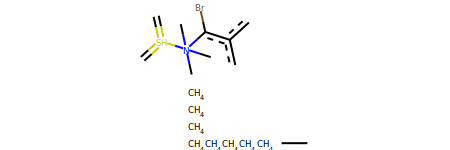

In [47]:
smiles = "C.C.C.C.C.C.C.C=S(=C)(=C)N(C)(C)(C)c(Br)c(c)c.CC"
smiles = "C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC"
from rdkit import Chem

from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smiles, sanitize = False)

In [48]:
# Chem.MolFromSmiles("C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC")

In [49]:
smiles

'C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC'

In [50]:
bonds_labels

tensor([4, 4, 0,  ..., 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [51]:
dev_sym

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [52]:
mol = feat2smiles(SYMBOLS,None,BOND_TYPES,dev_sym, None, dev_bnd)

In [59]:
mol

'C.C.C.C.C.C.C.C.C.C1CCC1.C=C.CCCC.CCO'

# Validity

In [68]:
from molgen.metrics.mol_metrics import MolMetrics
metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)

target = Y.get_graph_outputs()

In [83]:
metrics.batch_molecular_disconnected_validity(prediction, target)
metrics.batch_molecular_validity(prediction, target)
metrics.batch_symbol_accuracy(prediction, target)
metrics.batch_connected_components(prediction, target)
metrics.batch_invalid_valency_nodes(prediction, target)

100.0

In [80]:
feat2smiles()

TypeError: feat2smiles() missing 6 required positional arguments: 'SYMBOLS', 'FORMAL_CHARGES', 'BOND_TYPES', 'symbols', 'charges', and 'bonds'

In [70]:
target

array([{'SYMBOLS': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]), 'FORMAL_CHARGES': tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), 'BOND_TYPES': tensor([[[0., 0., 0., 0., 1.],
 

In [207]:
molopt.ref

tensor([[-1.2517,  0.4915, -1.9540,  ..., -0.4416,  1.1475, -1.9537],
        [-0.2895,  0.4184,  0.2665,  ..., -2.4453, -0.5888,  0.2592],
        [-0.3932, -0.6139,  0.9896,  ..., -0.4043,  1.3791, -1.6461],
        ...,
        [ 1.2792,  0.6248, -1.1144,  ...,  0.5200,  0.0337, -0.4816],
        [-0.9822,  0.5073, -0.6295,  ..., -1.6160, -0.6144, -0.7320],
        [ 0.3101,  0.2944, -0.4003,  ..., -1.0795, -0.3007,  0.0121]],
       device='cuda:0', requires_grad=True)

In [57]:
ft = {
    "SYMBOLS" : SYMBOLS,
    "BOND_TYPES" : BOND_TYPES,
    "FORMAL_CHARGES" : FORMAL_CHARGES
}
Penalty(ft)

In [58]:
BOND_TYPES

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.TRIPLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 None]